In [1]:
import torch
from torch import nn

import helper
from helper import *

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import cc3d
import numpy as np

#DATA

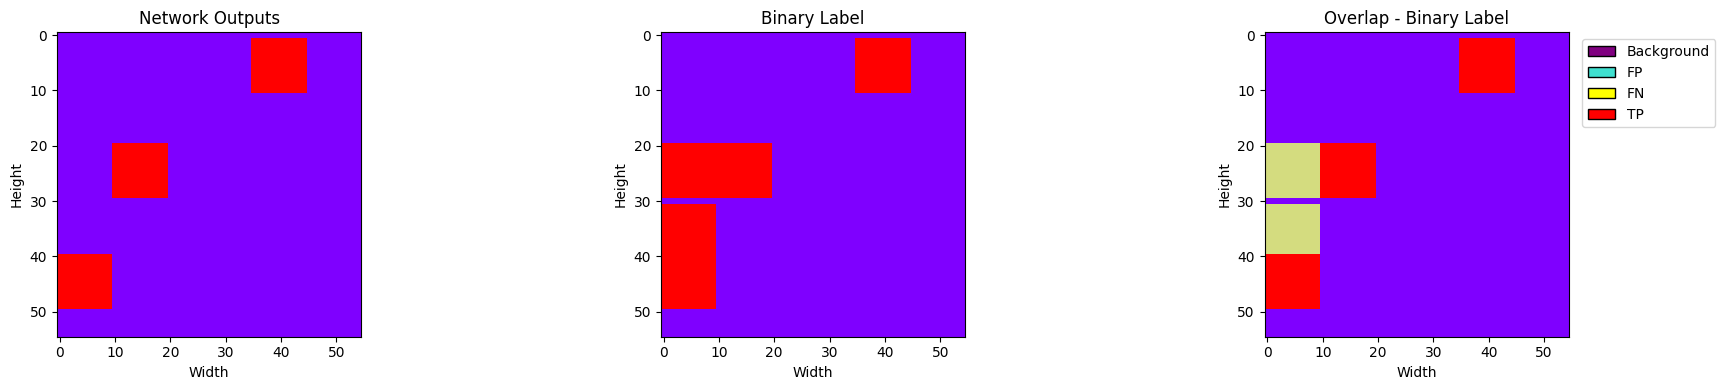

In [2]:
# Initialize tensors
network_outputs = torch.zeros(1, 55, 55)  # 1 batch, 1 channel, 55x55 size
binary_label = torch.zeros(1, 55, 55)      # 1 batch, 1 channel, 55x55 size

''' 100% overlap '''
network_outputs[:, 1:11, 35:45] = 1
binary_label[:, 1:11, 35:45] = 1

''' 50% overlap '''
network_outputs[:, 20:30, 10:20] = 1
binary_label[:, 20:30, 0:20] = 1

''' 25% overlap '''
network_outputs[:, 40:50, 0:10] = 1
binary_label[:, 31:50, 0:10] = 1

''' 0% overlap '''

display_binary_label = binary_label * 2

# Adjusting the figure size
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# Adjusting color maps and adding color bars
im0 = ax[0].imshow(network_outputs[0, :, :], cmap='rainbow')
ax[0].set_title("Network Outputs")
# fig.colorbar(im0, ax=ax[0])
ax[0].set_xlabel('Width')
ax[0].set_ylabel('Height')

im1 = ax[1].imshow(display_binary_label[0, :, :], cmap='rainbow')
ax[1].set_title("Binary Label")
# fig.colorbar(im1, ax=ax[1])
ax[1].set_xlabel('Width')
ax[1].set_ylabel('Height')

im2 = ax[2].imshow(network_outputs[0, :, :] + display_binary_label[0, :, :], cmap='rainbow')
ax[2].set_title("Overlap - Binary Label")
# fig.colorbar(im2, ax=ax[2])
ax[2].set_xlabel('Width')
ax[2].set_ylabel('Height')

legend_elements = [Patch(facecolor='purple', edgecolor='black', label='Background'),
                   Patch(facecolor='turquoise', edgecolor='black', label='FP'),
                   Patch(facecolor='yellow', edgecolor='black', label='FN'),
                   Patch(facecolor='red', edgecolor='black', label='TP')]

ax[2].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))


plt.tight_layout()
plt.show()

#PLAIN DICE LOSS

In [3]:
DiceLoss= DiceLoss()
loss = DiceLoss(network_outputs, binary_label)
print(loss)

tensor(0.2402)


#INDIVIUAL compute_compound_loss CALCULATION

losses: [tensor(0.7595)]
loss: tensor(0.7595)


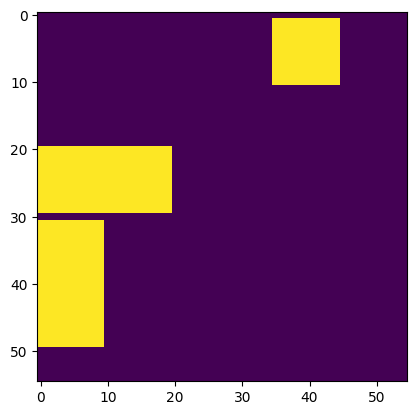

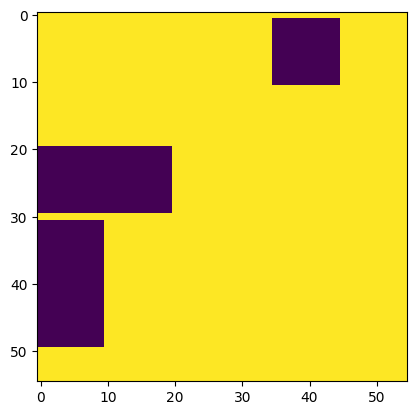

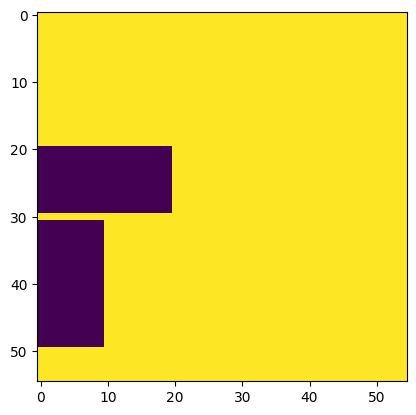

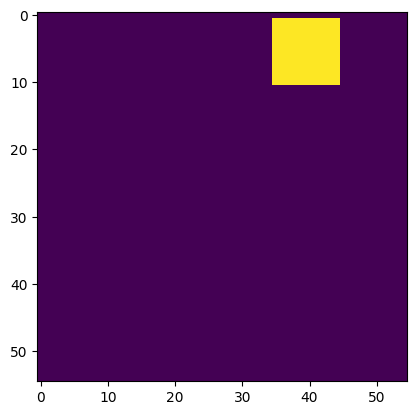

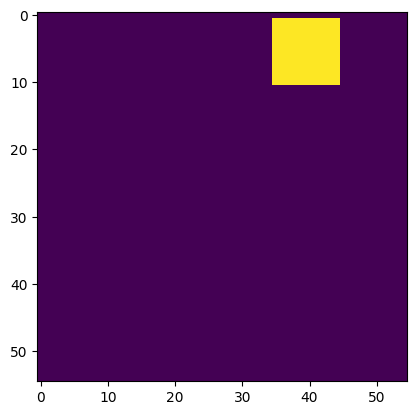

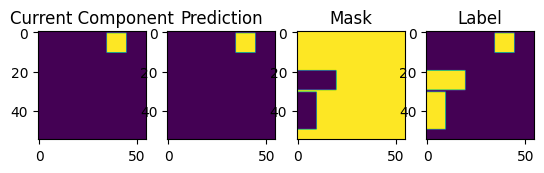

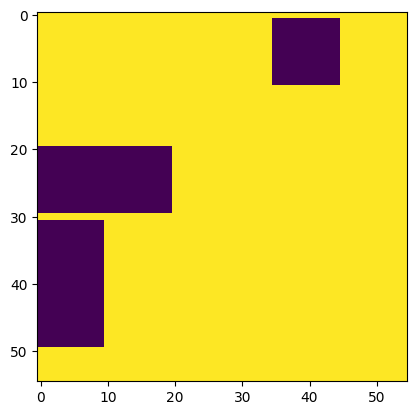

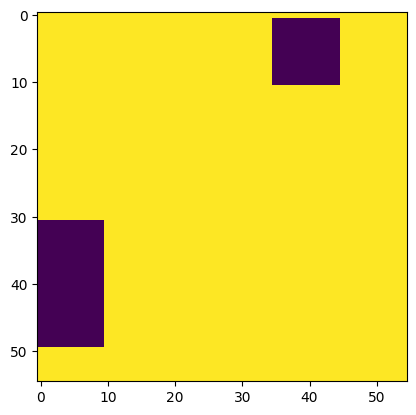

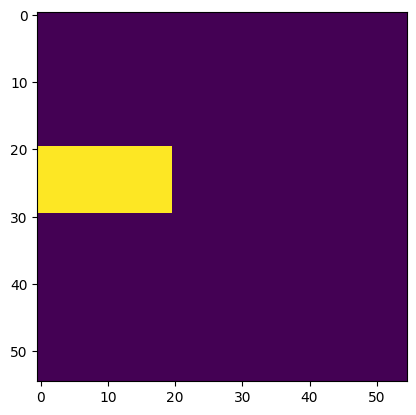

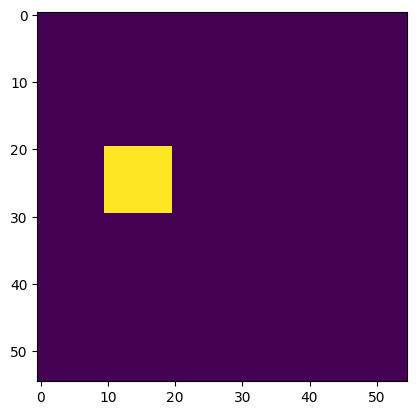

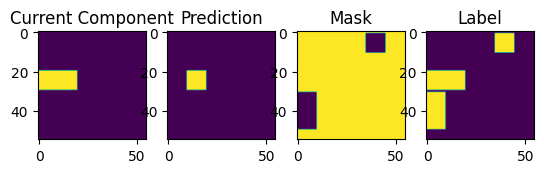

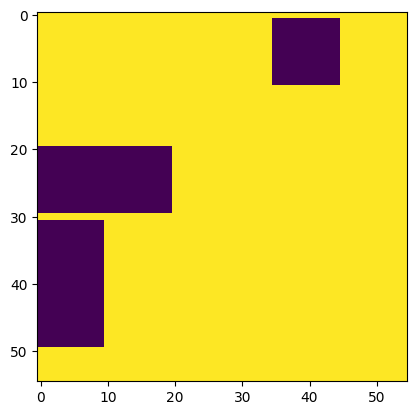

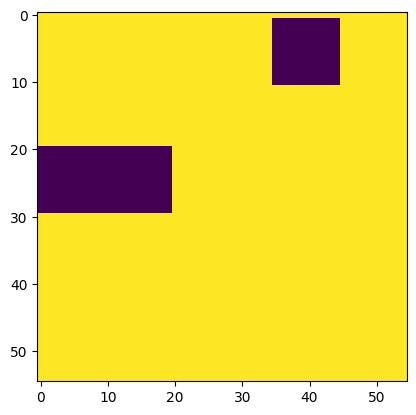

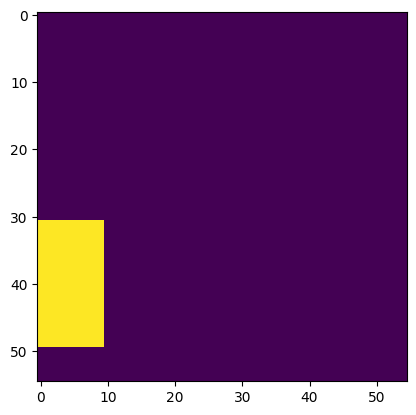

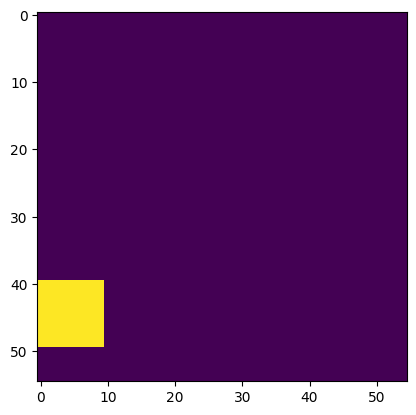

losses: [tensor(0.7854)]
loss: tensor(0.7854)
Main Loss: 0.7594936490058899
Blob Loss: 0.7854406237602234
Legacy Dice: 0.7594936490058899


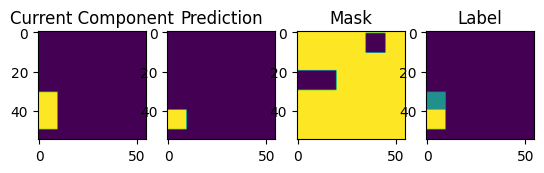

In [4]:
multi_label = cc3d.connected_components(binary_label[0, ...].numpy())
multi_label = torch.tensor(multi_label.astype(np.float64)).unsqueeze(0).unsqueeze(0)

legacy_dice = helper.dice(network_outputs[0, ...], binary_label[0, ...])

main_loss = compute_compound_loss(
    criterion_dict={"dice": {"name": "dice", "loss": dice, "weight": 1.0, "sigmoid": False}},
    raw_network_outputs=network_outputs,
    label= binary_label,
    blob_loss_mode=False,
)

blob_loss = compute_compound_loss(
    criterion_dict={"dice": {"name": "dice", "loss": dice, "weight": 1.0, "sigmoid": False}},
    raw_network_outputs=network_outputs,
    label= multi_label,
    blob_loss_mode=True,
)

print('Main Loss:', main_loss.item())
print('Blob Loss:', blob_loss.item())
print('Legacy Dice:', legacy_dice.item())

#compute_loss CALCULATION (THIS IS THE MAIN FUNCTION IN FLORIAN'S CODE)

losses: [tensor(0.2402)]
loss: tensor(0.2402)


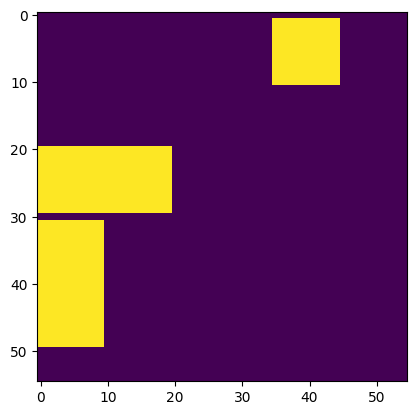

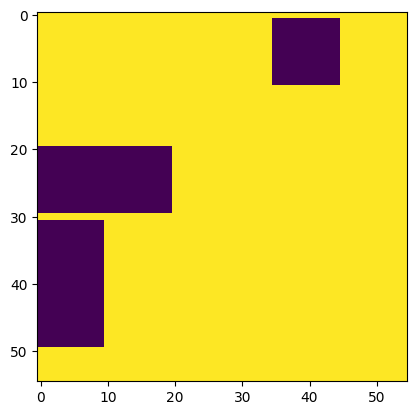

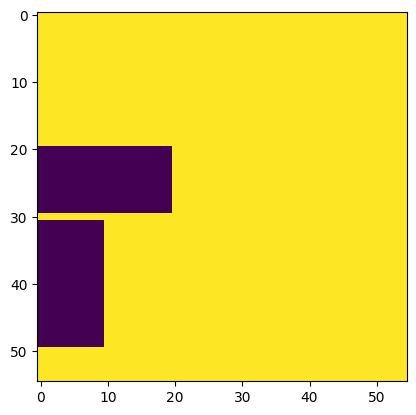

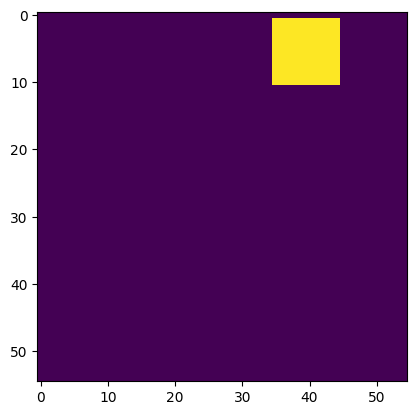

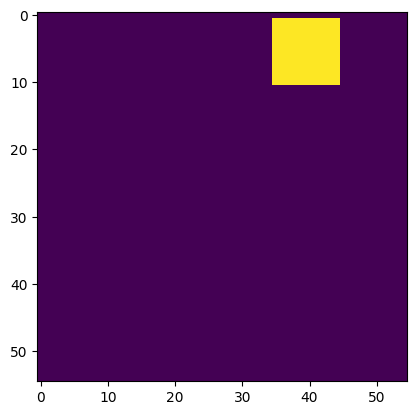

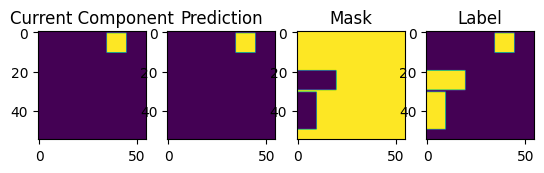

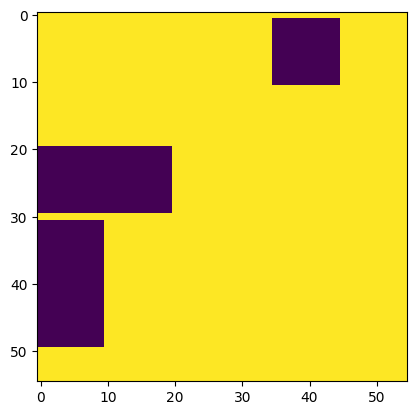

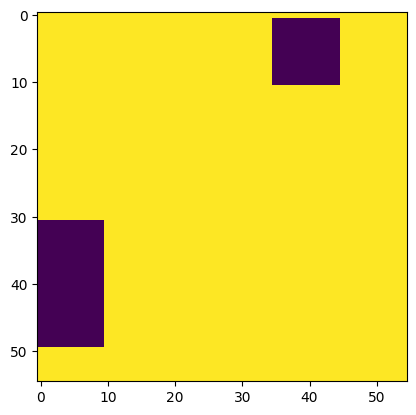

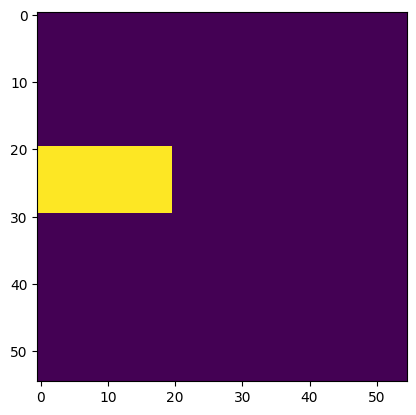

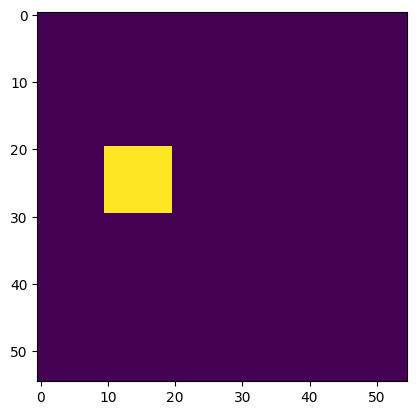

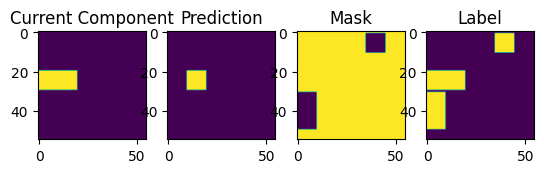

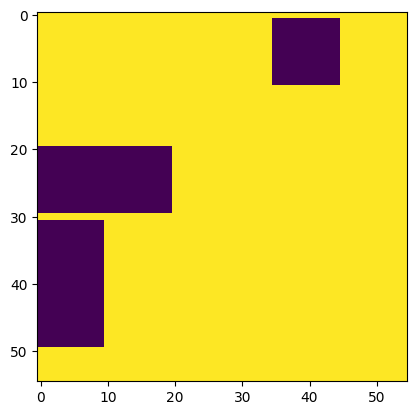

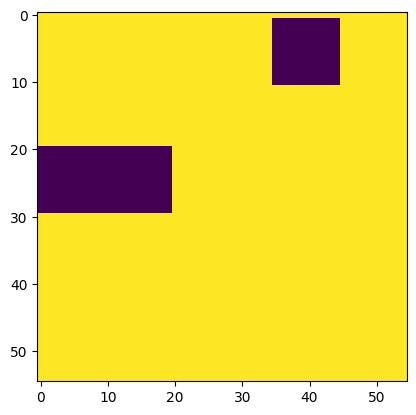

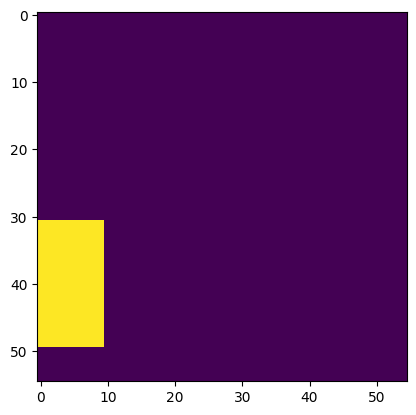

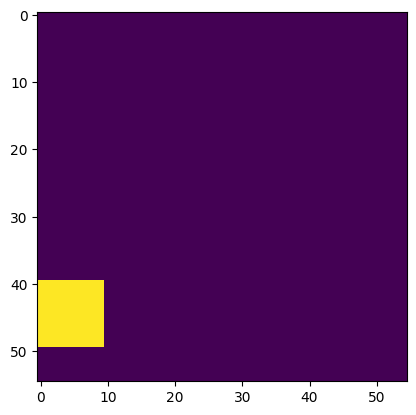

losses: [tensor(0.2138)]
loss: tensor(0.2138)
Loss: 0.45403701066970825
Main Loss: 0.24020224809646606
Blob Loss: 0.2138347625732422


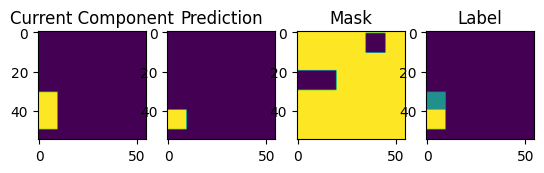

In [5]:
loss, main_loss, blob_loss = compute_loss(
    blob_loss_dict={"main_weight": 1, "blob_weight": 1},
    criterion_dict={"dice": {"name": "dice", "loss": DiceLoss, "weight": 1, "sigmoid": False}},
    blob_criterion_dict={"dice": {"name": "dice", "loss": DiceLoss, "weight": 1, "sigmoid": False}},
    raw_network_outputs=network_outputs,
    binary_label=binary_label,
    multi_label=multi_label,
)

print('Loss:', loss.item())
print('Main Loss:', main_loss.item())
print('Blob Loss:', blob_loss.item())

losses: [tensor(6.2810)]
loss: tensor(6.2810)


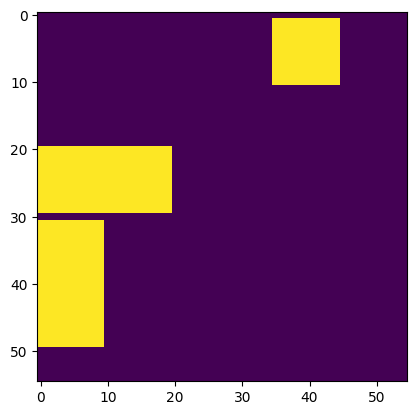

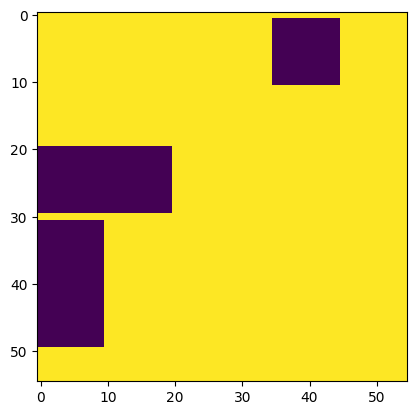

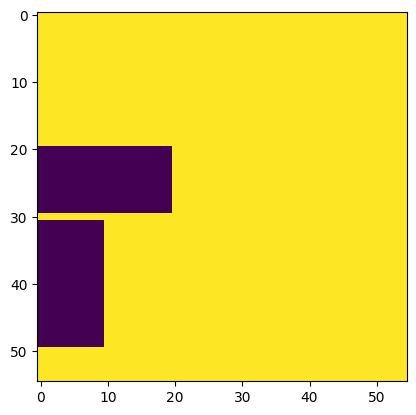

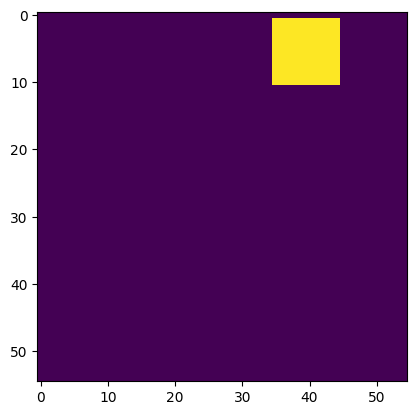

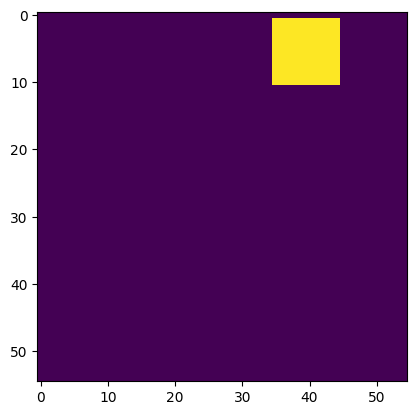

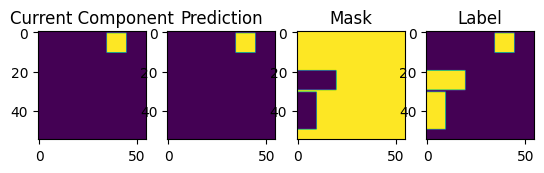

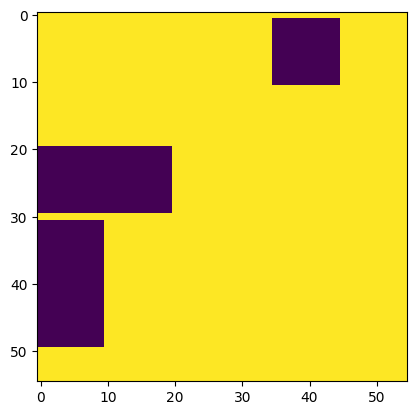

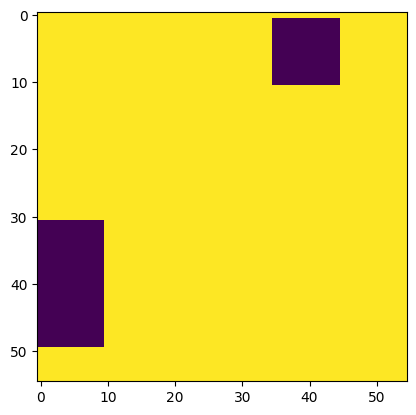

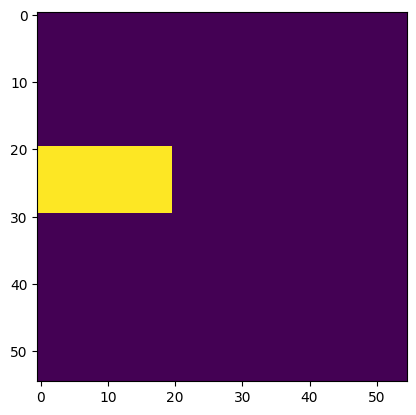

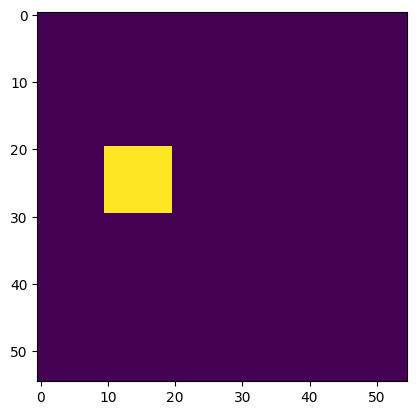

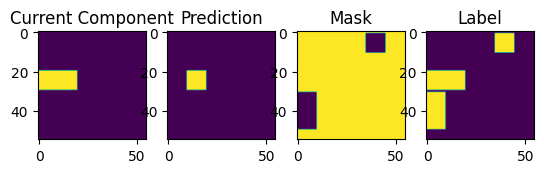

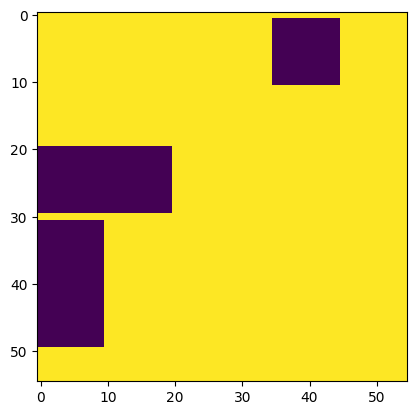

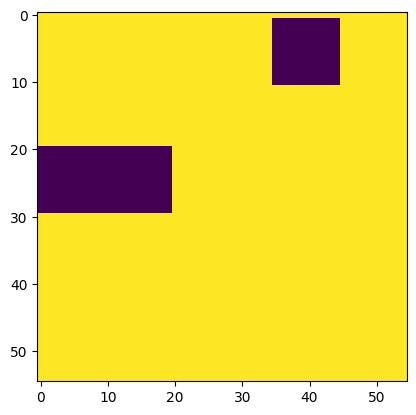

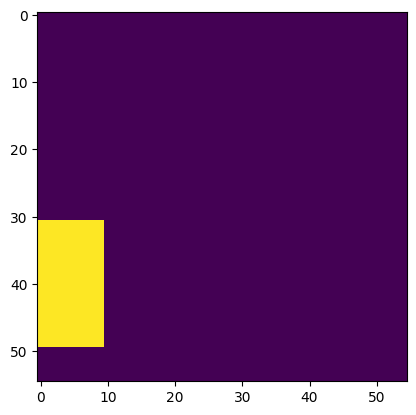

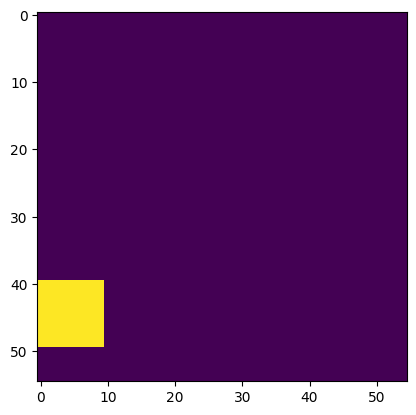

losses: [tensor(2.0937)]
loss: tensor(2.0937)
Loss: 8.374655723571777
Main Loss: 6.280991554260254
Blob Loss: 2.0936639308929443


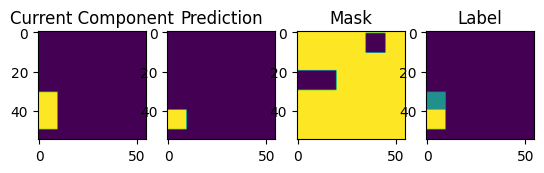

In [6]:
loss, main_loss, blob_loss = compute_loss(
    blob_loss_dict={"main_weight": 1, "blob_weight": 1},
    criterion_dict={"BCE": {"name": "BCE", "loss": nn.BCELoss(reduction="mean"), "weight": 1, "sigmoid": False}},
    blob_criterion_dict={"BCE": {"name": "BCE", "loss": nn.BCELoss(reduction="mean"), "weight": 1, "sigmoid": False}},
    raw_network_outputs=network_outputs,
    binary_label=binary_label,
    multi_label=multi_label,
)

print('Loss:', loss.item())
print('Main Loss:', main_loss.item())
print('Blob Loss:', blob_loss.item())

#The difference of using sigmoid

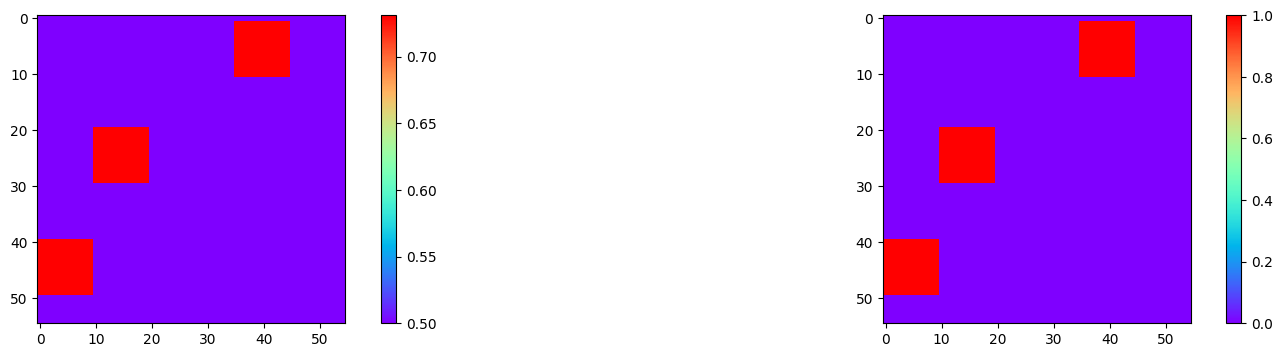

In [7]:
network_outputs_sig = torch.sigmoid(network_outputs)

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
im1 = ax[0].imshow(network_outputs_sig[0, ...], cmap='rainbow')
im2 = ax[1].imshow(network_outputs[0, ...], cmap='rainbow')

# Add colorbars
cbar1 = fig.colorbar(im1, ax=ax[0])
cbar2 = fig.colorbar(im2, ax=ax[1])

plt.show()

#Using 2 losses for the criterion

losses: [tensor(6.2810), tensor(0.2402)]
loss: tensor(6.5212)


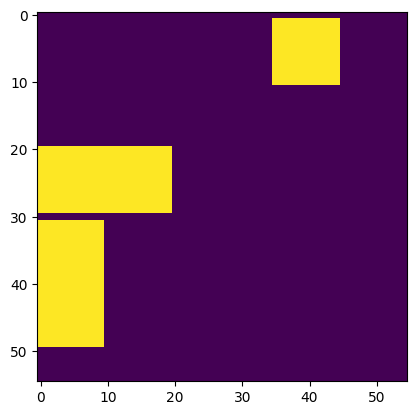

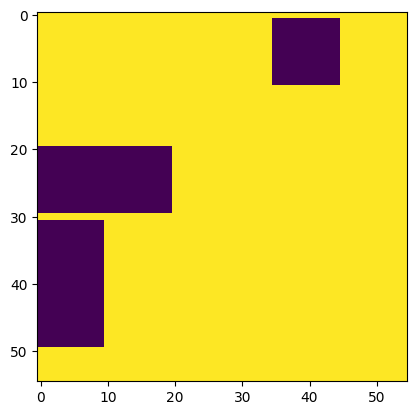

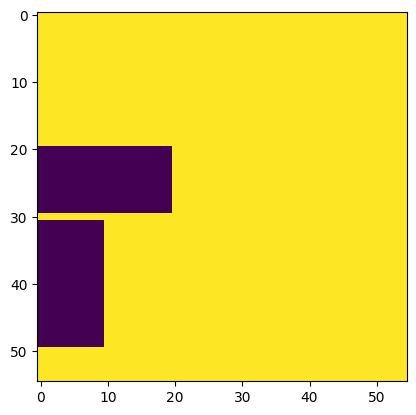

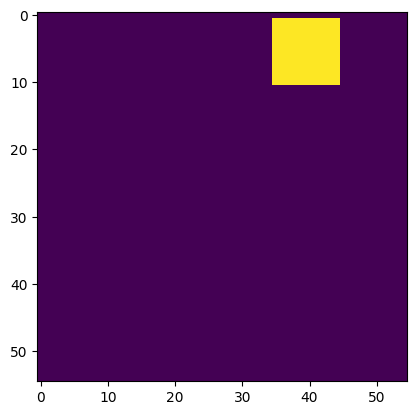

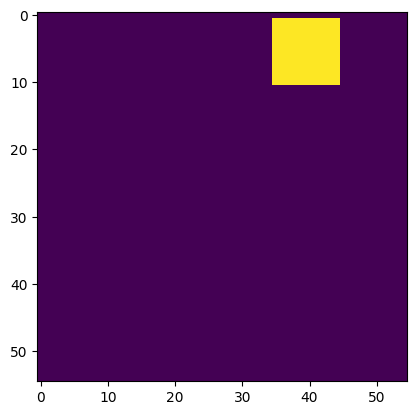

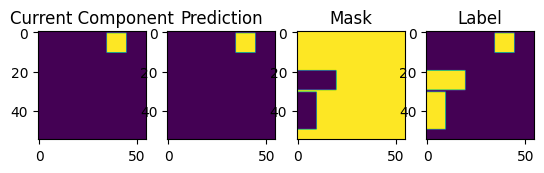

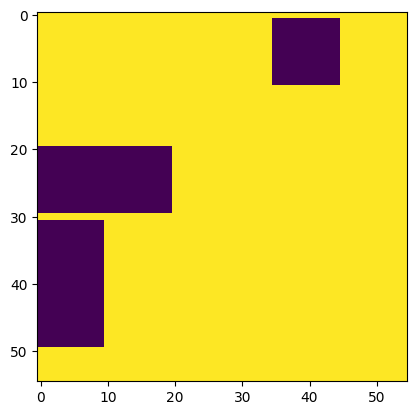

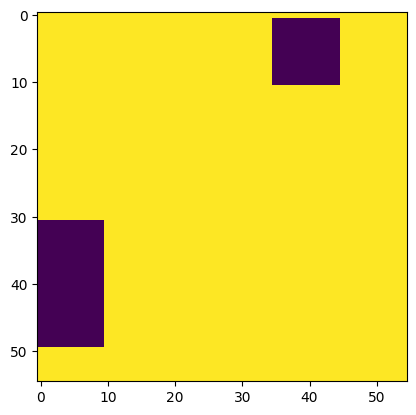

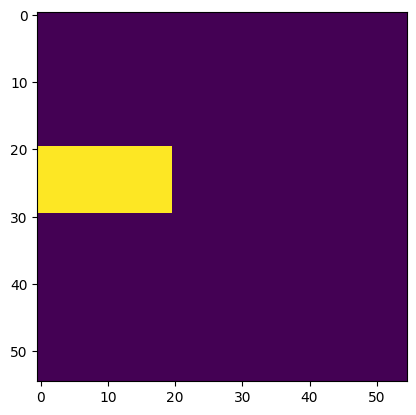

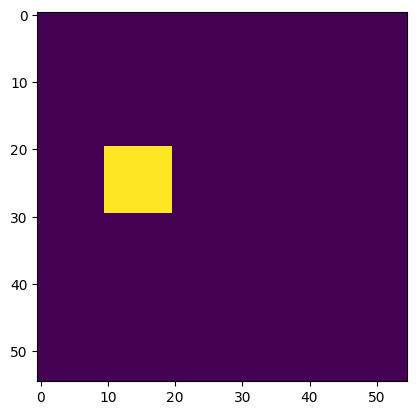

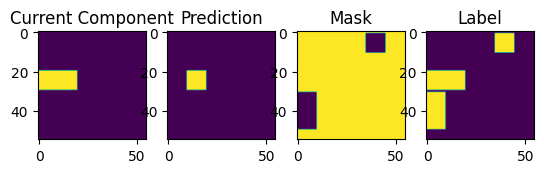

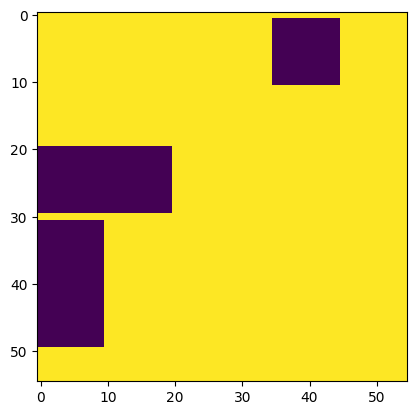

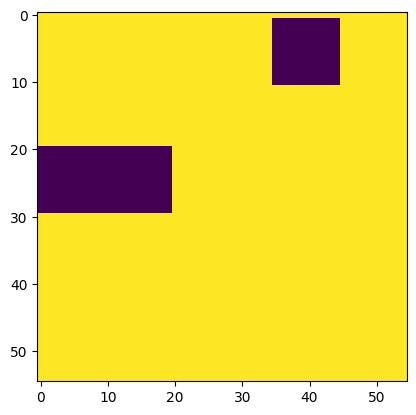

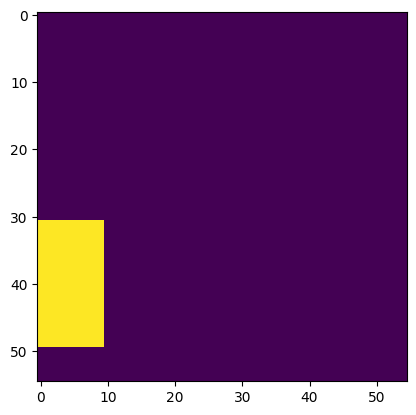

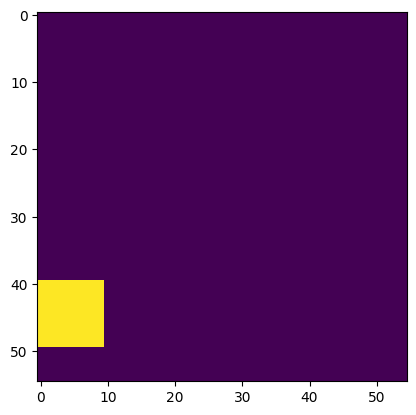

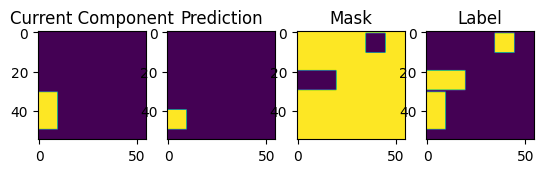

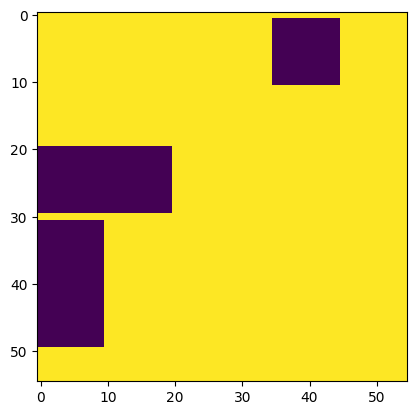

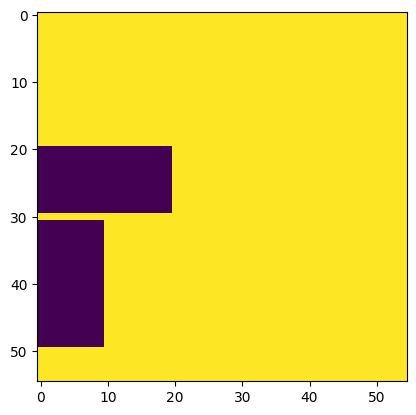

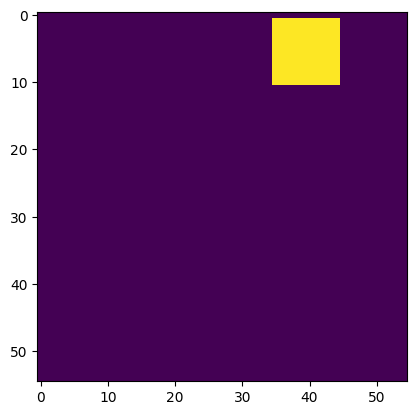

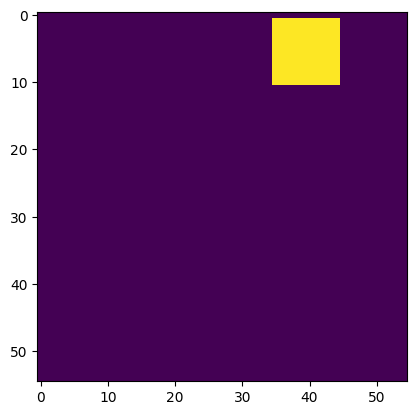

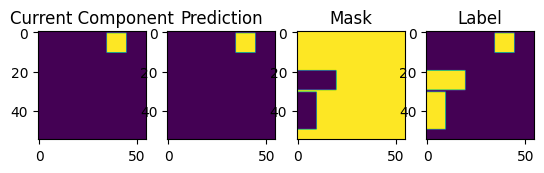

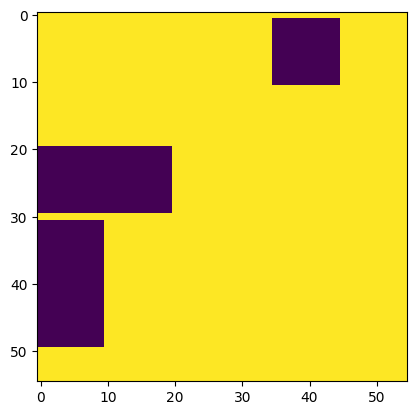

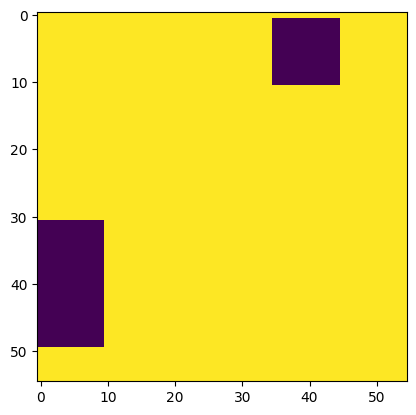

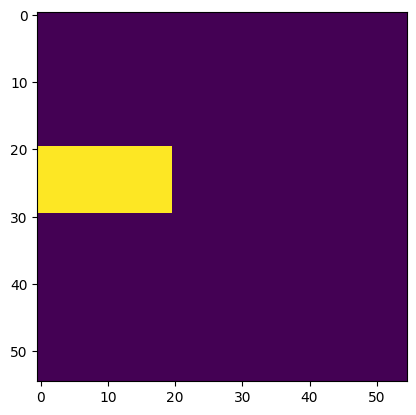

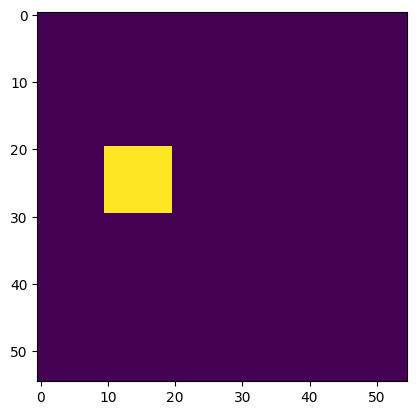

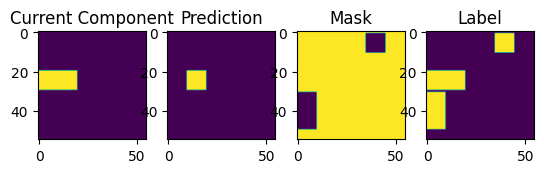

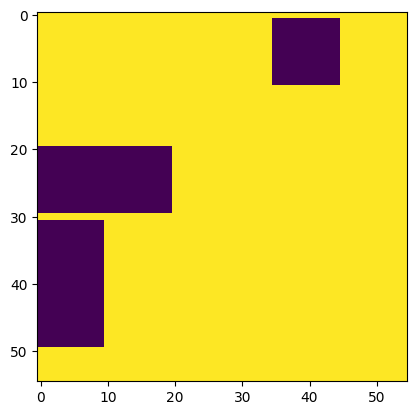

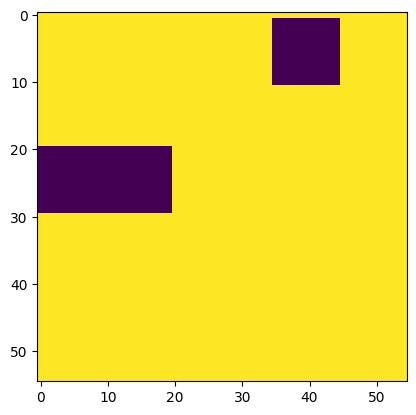

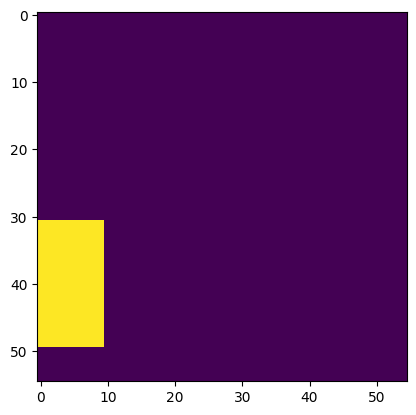

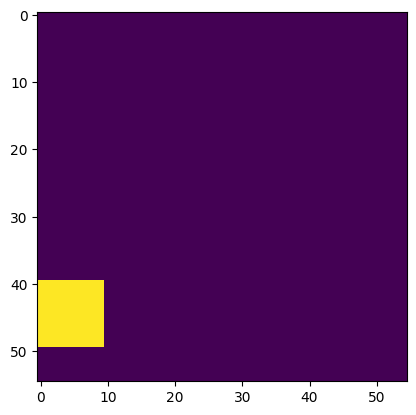

losses: [tensor(2.0937), tensor(0.2138)]
loss: tensor(2.3075)
Loss: 8.828692436218262
Main Loss: 6.521193981170654
Blob Loss: 2.3074986934661865


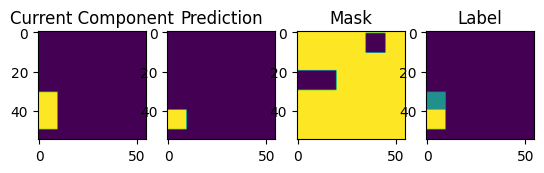

In [8]:
loss, main_loss, blob_loss = compute_loss(
    blob_loss_dict={"main_weight": 1, "blob_weight": 1},
    criterion_dict={"BCE": {"name": "BCE", "loss": nn.BCELoss(reduction="mean"), "weight": 1, "sigmoid": False},
                    "dice": {"name": "dice", "loss": DiceLoss, "weight": 1, "sigmoid": False}},
    blob_criterion_dict={"BCE": {"name": "BCE", "loss": nn.BCELoss(reduction="mean"), "weight": 1, "sigmoid": False},
                         "dice": {"name": "dice", "loss": DiceLoss, "weight": 1, "sigmoid": False}},
    raw_network_outputs=network_outputs,
    binary_label=binary_label,
    multi_label=multi_label,
)

print('Loss:', loss.item())
print('Main Loss:', main_loss.item())
print('Blob Loss:', blob_loss.item())

#The new version of ce loss

In [ ]:
# Tom's Suggestions: Blob Loss with only dice + BCE !!